In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import signal
import copy
from tslearn.preprocessing import TimeSeriesResampler
import seaborn as sns
from tslearn.metrics import dtw_path, dtw


In [2]:
def Bessel_Filter(data,sampling_frequency=100,order=4,cut_off_frequency=8):
    normalized_cutoff=cut_off_frequency/(0.5*sampling_frequency)
    b,a=signal.bessel(order, normalized_cutoff, btype='low', analog=False)
    filtered_data=signal.filtfilt(b,a,data)
    return filtered_data

#downsampling
# data:2D array(time, current) 
def Down_sampling(data, factor):
    down_sampled_data=signal.decimate(data,factor)
    return down_sampled_data
 
#interplotation data:2D array   
def interplotation(data,target_length):
    inter_func = interp1d(data.iloc[:,0], data.iloc[:,1], kind='cubic')  # 使用三次样条插值
    time_new=np.linspace(data.iloc[0,0],data.iloc[-1,0],target_length)
    current_interpolated = inter_func(time_new)
    return pd.DataFrame(np.array([time_new, current_interpolated]).T)



#data: (n,2) dataframe
def normalized_translocation(data,threshold=450,drop_head=5,drop_tail=-5):
    translocation_region=data[data.iloc[:,1]<threshold]
    translocation_region=translocation_region.iloc[drop_head:drop_tail,:]
    translocation_region.iloc[:,1]=(translocation_region.iloc[:,1]-translocation_region.iloc[:,1].mean())/translocation_region.iloc[:,1].std()
    translocation_region.iloc[:,0]=translocation_region.iloc[:,0]-translocation_region.iloc[0,0]
    return translocation_region

#time, current:1D array

def Draw_Plot(time,current,format="-", start=0, end=None,x_range=60):
    plt.plot(time[start:end],current[start:end])
    plt.xlabel('Time/ms')
    plt.ylabel('Current/pA')
    plt.grid=False
    plt.xlim(0,x_range)
    
def normalized_time_axis(data):
    normalized_translocation_region=copy.deepcopy(data)
    normalized_translocation_region.iloc[:,0]=(normalized_translocation_region.iloc[:,0]-min(normalized_translocation_region.iloc[:,0]))/(max(normalized_translocation_region.iloc[:,0])-min(normalized_translocation_region.iloc[:,0]))
    return normalized_translocation_region
    

In [3]:
def Signal_Processing(file_name,start=None, end=None, upper_lim=700,lower_lim=200,sampling_frequency=100,cut_off_frequency=2):
    if file_name[-3:]=='lsx':
        original_data=pd.read_excel(file_name)
    elif file_name[-3:]=='csv':
        original_data=pd.read_csv(file_name)
        
    data_cleared=original_data.dropna(axis=1,how='all')
    #slice different serieses
    data_sliced = []
    column_num = len(data_cleared.columns)

    for i in range(0, column_num, 2):
        df_sliced = data_cleared.iloc[:, i:i+2].copy()  # 使用 copy() 避免警告
        df_sliced.columns = ['t', 'i' ]
        # 删除所有值为空的行
        new_df_sliced = df_sliced.dropna(axis=0, how="all").copy()
        # 确保 new_df_sliced 不是空的再进行操作
        if not new_df_sliced.empty:
            new_df_sliced.loc[:, new_df_sliced.columns[0]] -= new_df_sliced.iloc[0, 0]
        data_sliced.append(new_df_sliced)
        
    #process the data
    #set parameters
    sampling_frequency=100
    
    processed_data=[]
    for series in data_sliced:
        filtered_current=Bessel_Filter(series['i'],sampling_frequency=sampling_frequency,cut_off_frequency=cut_off_frequency)
        filtered_curve=np.array([series['t'],filtered_current])
        if len(filtered_curve[0])>3000:
            down_sampled_curve=Down_sampling(filtered_curve, factor=3)
        else:
            down_sampled_curve=filtered_curve
        filtered_curve_dataframe=pd.DataFrame(down_sampled_curve.T)
        normalized_data=normalized_translocation(filtered_curve_dataframe,threshold=min(filtered_curve_dataframe.iloc[:,1])+60,drop_head=5)
        processed_data.append(normalized_data)

    #select data for further alignment
    target_data=[series for series in processed_data if len(series)<upper_lim and len(series)>lower_lim]
    
    #get the length of each selected signal and 
    len_target_data=[len(series) for series in target_data]
    max_len=max(len_target_data)
    max_index=[len(series) for series in target_data].index(max_len)

    #using time_axis normalization method to normallize the time 
    time_normalized_data=[normalized_time_axis(series) for series in target_data][start:end]
    
    return time_normalized_data

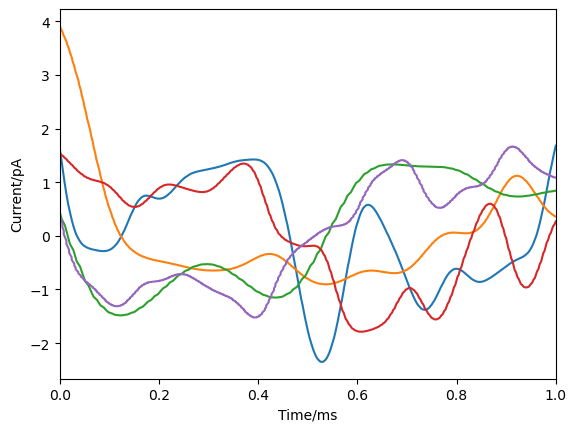

In [26]:
time_normalized_data=Signal_Processing('1.xlsx',upper_lim=700,lower_lim=200)
for series in time_normalized_data[0:5]:
    Draw_Plot(series.iloc[:,0],series.iloc[:,1],x_range=1)
    

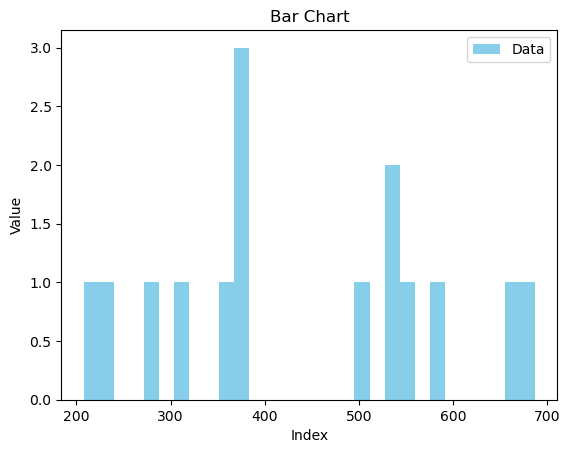

In [27]:
length_stat=[series.shape[0] for series in time_normalized_data]
plt.hist(length_stat, color='skyblue', bins=30)

# 设置图表标题和坐标轴标签
plt.title('Bar Chart')
plt.xlabel('Index')
plt.ylabel('Value')

# 添加图例
plt.legend(['Data'])

# 显示图表
plt.show()

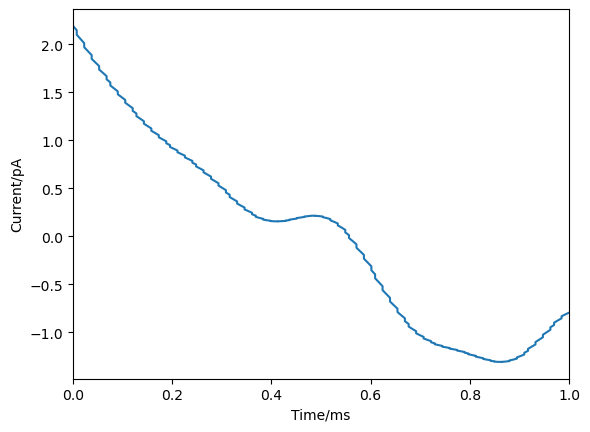

In [29]:
idx=np.argmin(np.array(length_stat))
Draw_Plot(time_normalized_data[idx].iloc[:,0],time_normalized_data[idx].iloc[:,1],x_range=1)

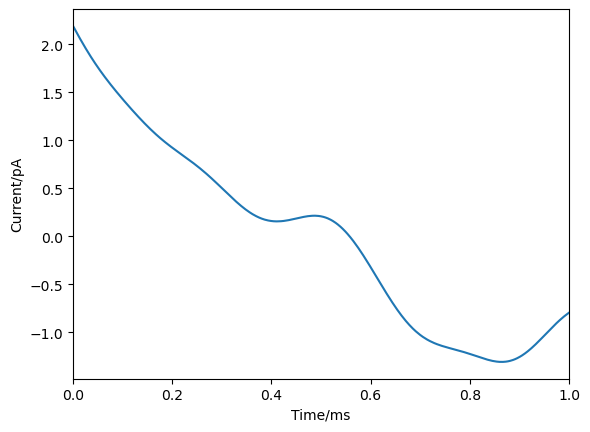

In [33]:
resample_size=700
sampler=TimeSeriesResampler(sz=resample_size)
x_axis=np.linspace(0,1,resample_size)
resampled_data=[sampler.fit_transform(series.iloc[:,1].to_numpy().T).ravel() for series in time_normalized_data]

Draw_Plot(x_axis,resampled_data[idx],x_range=1)

In [47]:
def dtw_alignment_interplotation(time_normalized_data,resample_length=None,plot_series=False,plot_alignment=False,show_matrix=False):
    dtw_matrix=np.zeros((len(time_normalized_data),len(time_normalized_data)))
    data_length=[series.shape[0] for series in time_normalized_data]
    
    series_resampler=TimeSeriesResampler(sz=max(data_length))
    resampled_current=[series_resampler.fit_transform(series.iloc[:,1].to_numpy().T).ravel() for series in time_normalized_data]
    resampled_time=[np.linspace(0,1,max(data_length)) for i in range(len(time_normalized_data))]
    resampled_data=[]
    for idx in range(0,len(time_normalized_data)):
        resampled_data.append(pd.DataFrame({'t':resampled_time[idx],'i':resampled_current[idx]}))
    
    for i in range(len(resampled_data)-1):
        for j in range (i+1, len(resampled_data)):
            series_1=resampled_data[i]
            series_2=resampled_data[j]
            distance=dtw(series_1,series_2)
            normalized_distance=distance/(len(series_1)+len(series_2))
            dtw_matrix[i,j]=normalized_distance
            dtw_matrix[j,i]=normalized_distance
    rows_sums=dtw_matrix.sum(axis=1)
    min_index=np.argmin(rows_sums)
    normalized_dtw_matrix=dtw_matrix/np.amax(dtw_matrix)
    if show_matrix==True:
        sns.heatmap(normalized_dtw_matrix, annot=False, fmt=".2f", cmap="YlGnBu")
        plt.show()
        print(len(rows_sums),min_index)

    aligned_data=[]
    series_standard=resampled_data[min_index]
    np_series_standard=series_standard.to_numpy()
    np_series_standard_time=np_series_standard[:,0].T
    np_series_standard_current=np_series_standard[:,1].T
    for i in range(len(resampled_data)-1):
        if i != min_index:
            series=resampled_data[i]
            standard_series=np_series_standard
            path,_=dtw_path(series,series_standard)
            aligned_series=np.zeros((len(path),2))
            aligned_standard_series=np.zeros((len(path),2))
            for i, (idx1, idx2) in enumerate(path):
                np_series=series.to_numpy()
                aligned_series[i] = np_series[idx1]
                aligned_standard_series[i]=standard_series[idx2]
            #aligned_series_time=[x[0] for x in aligned_series]
            aligned_series_current=[x[1] for x in aligned_series]
            aligned_standard_series_time=[x[0] for x in aligned_standard_series]
            aligned_data.append(np.array([aligned_standard_series_time,aligned_series_current]))
        else:
            aligned_data.append(np.array([np_series_standard_time,np_series_standard_current]))
        
    if plot_alignment==True:
        for series in aligned_data:
            plt.plot(series[0,:], series[1,:])
        plt.show()

    #align_data_after_dtw-align with the longeset data
    aligned_data_unique=[]
    for series in aligned_data:
        unique_series_time,idx=np.unique(series[0,:],return_index=True)
        unique_series_current=series[1,:][idx]
        aligned_data_unique.append(np.array([unique_series_time,unique_series_current]))
        
    len_aligned_data=np.array([series.shape[1] for series in aligned_data_unique])
    max_aligned_len=len_aligned_data.max()
    max_len_index=np.argmax(len_aligned_data)
    
    len_aligned_data=np.array([series.shape[1] for series in aligned_data_unique])
    max_aligned_len=len_aligned_data.max()
    max_len_index=np.argmax(len_aligned_data)


    resampler=TimeSeriesResampler(sz=max_aligned_len if resample_length is None else resample_length)
    
    interplotation_aligned_data=[resampler.fit_transform(series[-1,:]).ravel() for series in aligned_data_unique]
    average_current=np.sum(interplotation_aligned_data,axis=0)
    average_current/=len(interplotation_aligned_data)
    
    if plot_series==True:
        time=np.linspace(0,1,max_aligned_len)
        plt.plot(time,average_current,color='blue')
        plt.plot(np_series_standard_time,np_series_standard_current,color='red')
        plt.show()
        
    return aligned_data_unique,average_current

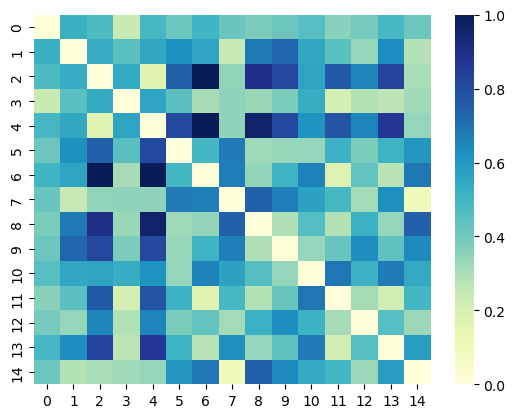

15 3


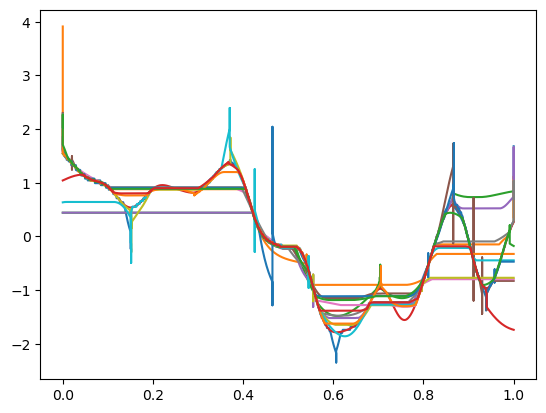

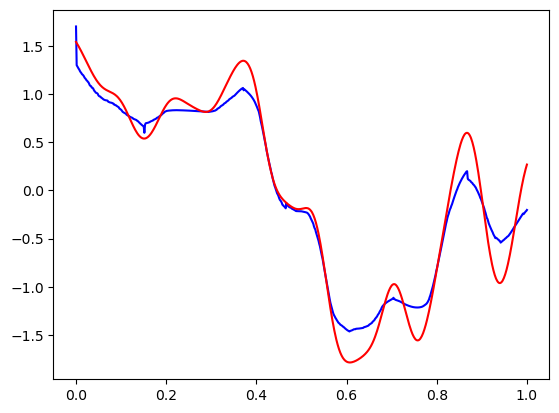

In [57]:
time_normalized_data=Signal_Processing('1.xlsx',start=0,end=20,upper_lim=700,lower_lim=200,cut_off_frequency=2)
aligned_series=dtw_alignment_interplotation(time_normalized_data,plot_series=True,plot_alignment=True,show_matrix=True)

In [61]:
from tslearn.metrics import soft_dtw_alignment, soft_dtw

In [62]:
def dtw_alignment(time_normalized_data,resample_length=None,plot_series=False,plot_alignment=False,show_matrix=False):
    dtw_matrix=np.zeros((len(time_normalized_data),len(time_normalized_data)))

    for i in range(len(time_normalized_data)-1):
        for j in range (i+1, len(time_normalized_data)):
            series_1=time_normalized_data[i]
            series_2=time_normalized_data[j]
            distance=soft_dtw(series_1,series_2)
            normalized_distance=distance/(len(series_1)+len(series_2))
            dtw_matrix[i,j]=normalized_distance
            dtw_matrix[j,i]=normalized_distance
    rows_sums=dtw_matrix.sum(axis=1)
    min_index=np.argmin(rows_sums)
    normalized_dtw_matrix=dtw_matrix/np.amax(dtw_matrix)
    if show_matrix==True:
        sns.heatmap(normalized_dtw_matrix, annot=False, fmt=".2f", cmap="YlGnBu")
        plt.show()
        print(len(rows_sums),min_index)

    aligned_data=[]
    series_standard=time_normalized_data[min_index]
    np_series_standard=series_standard.to_numpy()
    np_series_standard_time=np_series_standard[:,0].T
    np_series_standard_current=np_series_standard[:,1].T
    for i in range(len(time_normalized_data)-1):
        if i != min_index:
            series=time_normalized_data[i]
            standard_series=np_series_standard
            distance,path=soft_dtw_alignment(series,series_standard)
            print(distance,path)
            aligned_series=np.zeros((len(path),2))
            aligned_standard_series=np.zeros((len(path),2))
            for i, (idx1, idx2) in enumerate(path):
                np_series=series.to_numpy()
                aligned_series[i] = np_series[idx1]
                aligned_standard_series[i]=standard_series[idx2]
            #aligned_series_time=[x[0] for x in aligned_series]
            aligned_series_current=[x[1] for x in aligned_series]
            aligned_standard_series_time=[x[0] for x in aligned_standard_series]
            aligned_data.append(np.array([aligned_standard_series_time,aligned_series_current]))
        else:
            aligned_data.append(np.array([np_series_standard_time,np_series_standard_current]))
        
    if plot_alignment==True:
        for series in aligned_data:
            plt.plot(series[0,:], series[1,:])
        plt.show()

    #align_data_after_dtw-align with the longeset data
    aligned_data_unique=[]
    for series in aligned_data:
        unique_series_time,idx=np.unique(series[0,:],return_index=True)
        unique_series_current=series[1,:][idx]
        aligned_data_unique.append(np.array([unique_series_time,unique_series_current]))
        
    len_aligned_data=np.array([series.shape[1] for series in aligned_data_unique])
    max_aligned_len=len_aligned_data.max()
    max_len_index=np.argmax(len_aligned_data)


    resampler=TimeSeriesResampler(sz=max_aligned_len if resample_length is None else resample_length)
    
    interplotation_aligned_data=[resampler.fit_transform(series[-1,:]).ravel() for series in aligned_data_unique]
    average_current=np.sum(interplotation_aligned_data,axis=0)
    average_current/=len(interplotation_aligned_data)
    
    if plot_series==True:
        time=np.linspace(0,1,max_aligned_len)
        plt.plot(time,average_current,color='blue')
        plt.plot(np_series_standard_time,np_series_standard_current,color='red')
        plt.show()
        
    return aligned_data_unique,average_current

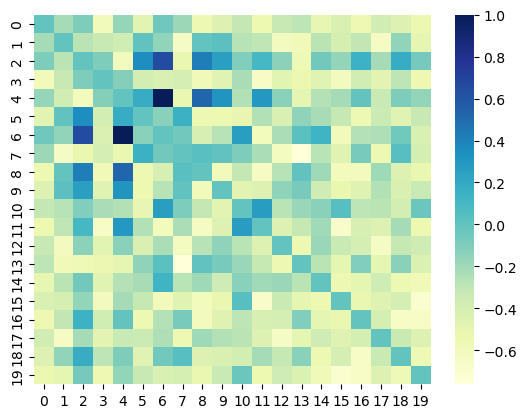

20 15
[[1.00000000e+00 9.13720340e-01 8.04774132e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.64948745e-02 1.27679971e-01 2.41984164e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.27209451e-04 4.28698996e-03 1.91139436e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.25833130e-01
  3.59661229e-01 7.28293404e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.19126876e-01
  6.08279605e-01 2.96395646e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.50634798e-01
  4.61794676e-01 1.00000000e+00]] -411.5048905134524


TypeError: object of type 'numpy.float64' has no len()

In [63]:
time_normalized_data=Signal_Processing('1.xlsx',start=0,end=20,upper_lim=700,lower_lim=200,cut_off_frequency=2)
aligned_series=dtw_alignment(time_normalized_data,plot_series=True,plot_alignment=True,show_matrix=True)


In [64]:
from tslearn.metrics import soft_dtw_alignment
import numpy as np

# 生成两个时间序列
X = np.array([[1, 2, 3]]).T  # (3,1) 形状
Y = np.array([[2, 2, 3]]).T  # (3,1) 形状

# 计算 Soft-DTW 距离和路径
distance, path = soft_dtw_alignment(X, Y, gamma=1.0)

print("Soft-DTW Distance:", distance)
print("Alignment Path:")
print(path)

Soft-DTW Distance: [[1.00000000e+00 1.63407339e-01 5.21722125e-04]
 [4.71254076e-01 8.65077724e-01 2.12352705e-01]
 [2.84850628e-02 2.89261412e-01 1.00000000e+00]]
Alignment Path:
-0.5583754402791056


In [13]:
import pandas as pd
data = {
    'col1': [1, 2, 3, 4, 5],
    'col2': [6, 7, 8, 9, 10]
}
df = pd.DataFrame(data)
df['col1'].values

array([1, 2, 3, 4, 5])